# Single-Server Queue FIFO

Import all the required Libraries

In [225]:
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

### Step 1: Generate array of Arrivals

In [226]:
np.random.seed(0)
slots = 1000 # Number of slots = number of arrivals (customers)

lam = 0.5 
interarrival_times = np.random.exponential(1/lam, size=slots)
arrival_times = np.cumsum(interarrival_times) # Arrival times are the cumulative sum of interarrival times


### Step 2: Generate array of Service Times

In [227]:
mu = 1
serviceDurations = np.random.exponential(1/mu, slots) # Service times are exponentially distributed with mean 1/mu



Simulating the queue (Service start times, Departure times, Waiting times and System times)

### Step 3: Simulate the Queue

In [228]:
# Initializing arrays to hold service start times, departure times, waiting times, and system times
service_start_times = np.empty(slots)
departure_times = np.empty(slots)
waiting_times = np.empty(slots)
system_times = np.empty(slots)

queue = []

for i in range(slots):
    if i == 0: # First customer (first arrival) - They are served immediately upon arrival (no waiting time)
        service_start_times[i] = arrival_times[i]
        departure_times[i] = service_start_times[i] + serviceDurations[i]
    else:
        service_start_times[i] = max(arrival_times[i], departure_times[i-1])
        departure_times[i] = service_start_times[i] + serviceDurations[i]
    
    waiting_times[i] = service_start_times[i] - arrival_times[i]
    system_times[i] = departure_times[i] - arrival_times[i]
    
   


\newpage

### Step 4: Performance metrics and design analysis

Created a function that generates service, departure, waiting and system times and outputs the mean value of the waiting times and the mean value of the system time

In [229]:
# The function takes in the arrival times, service durations and number of slots as inputs and outputs the mean waiting time and mean system time
def time_mean(arrival_times, serviceDurations, slots):
    service_start_times = np.empty(slots)
    departure_times = np.empty(slots)
    waiting_times = np.empty(slots)
    system_times = np.empty(slots)

    for i in range(slots): #loop through each customer and generate their service start time, departure time, waiting time and system time
        if i == 0:
            service_start_times[i] = arrival_times[i]
            departure_times[i] = service_start_times[i] + serviceDurations[i]
        else:
            service_start_times[i] = max(arrival_times[i], departure_times[i-1])
            departure_times[i] = service_start_times[i] + serviceDurations[i]
        
        waiting_times[i] = service_start_times[i] - arrival_times[i]
        system_times[i] = departure_times[i] - arrival_times[i]
    
    W_bar = np.sum(waiting_times)/slots  # Mean waiting time
    T_bar = np.sum(system_times)/slots  # Mean system time
    
    mean = np.array([W_bar, T_bar]) # Create an array to hold the mean waiting time and mean system time
    return mean, departure_times, service_start_times # Return the array


In [230]:
def calculating_Lq(arrival_times, service_start_times):
    def separate_by_intervals(times_array, interval_size=3):
        separated_arrays = []
        current_array = []
        current_interval_limit = interval_size

        for time in times_array:
            if time > current_interval_limit:
                # If the time exceeds the interval, save the current group
                separated_arrays.append(np.array(current_array))
                # Start a new group and move to the next interval
                current_array = [time]
                current_interval_limit += interval_size
            else:
                # Add the time to the current group
                current_array.append(time)

        # Add any remaining times to the list
        if current_array:
            separated_arrays.append(np.array(current_array))
            
        return separated_arrays
    
    separated_arrival_times = separate_by_intervals(arrival_times)
    separated_service_start_times = separate_by_intervals(service_start_times)

    queue_size_by_interval = []
    current_queue_count = 0

    # Loop through the intervals to calculate the queue size
    # We assume both lists have the same number of intervals
    for i in range(len(separated_arrival_times)):
        arrivals_in_interval = len(separated_arrival_times[i])
        departures_in_interval = len(separated_service_start_times[i])

        # Calculate the change in queue size for this interval
        change_in_queue = arrivals_in_interval - departures_in_interval

        # Update the running total
        current_queue_count += change_in_queue

        # Store the result for this interval
        queue_size_by_interval.append(current_queue_count)


    total_queue_length = sum(queue_size_by_interval)

    # Get the total number of intervals
    number_of_intervals = len(queue_size_by_interval)

    # Calculate the average queue length
    average_queue_length = total_queue_length / number_of_intervals
    
    return average_queue_length

Create a function that generates values of p, mean waiting time, mean system time, utilization and time-average queue length

The function takes in 4 different values of Lambda and Mu and generates the required parameters for each value of Lambda and Mu

In [231]:
def performance_metrics(params, slots): # Function takes in a 2D array of parameters (lambda, mu) and number of slots
    
    output_metrics = np.empty((params.shape[0], 7)) # Initialize an array to hold the output metrics for each parameter set
    
    for i in range(params.shape[0]): # Loop through each set of parameters (lambda, mu)
        lam = params[i][0]
        mu = params[i][1]
        
        interarrival_times = np.random.exponential(scale=1/lam, size=slots) # Generate new interarrival times for each parameter set
        arrival_times = np.cumsum(interarrival_times) # Get the arrival times for each parameter set
        serviceDurations = np.random.exponential(1/mu, slots) # Generate new service durations for each parameter set
        
        means, departure_times, service_start_times = time_mean(arrival_times, serviceDurations, slots) # Call the time_mean function to get mean waiting time and mean system time for each parameter set
        
        # get the mean waiting time and mean system time from the means array
        W_bar = means[0] # Mean waiting time
        T_bar = means[1] # Mean system time
        
        #calculate utilization which is the busy time of server divided by the total time
        
        utilization = (np.sum(serviceDurations))/(departure_times[-1] - arrival_times[0]) 
        
        p = lam/mu # value of p
        
        Lq = calculating_Lq(arrival_times, service_start_times)
        
        output_metrics[i] = np.array([lam, mu, p, W_bar, T_bar, utilization, Lq])
    
    return output_metrics
        
parameters = np.array([[0.5, 1.0], [0.7, 1.0], [0.9, 1.0], [0.95, 1.0]]) # Array of different (lambda, mu) pairs to test

output = performance_metrics(parameters, slots)

# print(output)

**Figure 1: plot W versus ρ**

Create a function that generates a smooth curve fit for data points that increase exponentially

In [232]:
def smooth_exponential_curve(x_axis, y_axis):
    log_y_axis = np.log(y_axis + 1e-9)

    # Perform a linear fit on the log-transformed data
    
    fit = np.polyfit(x_axis, log_y_axis, 1) # The '1' means a linear fit
    m, c = fit[0], fit[1] # m is slope, c is intercept

    # Create the smooth curve using the exponential function
    x_axis_smooth = np.linspace(x_axis.min(), x_axis.max(), 100)
    y_axis_smooth = np.exp(m * x_axis_smooth + c)
    
    return x_axis_smooth, y_axis_smooth

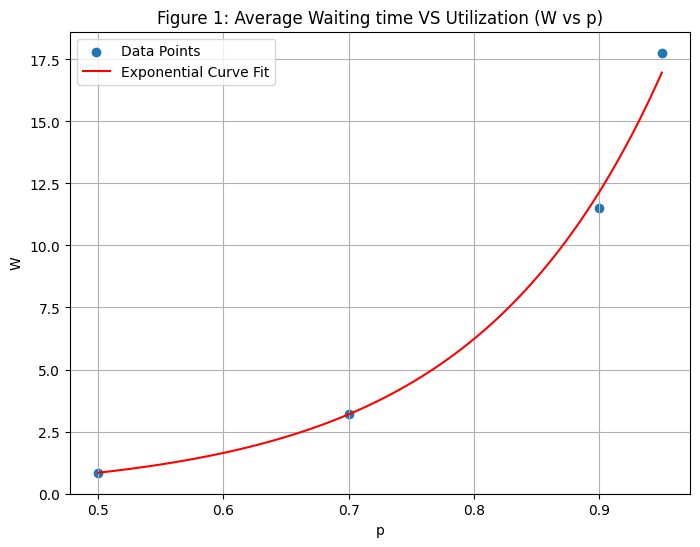

In [246]:
p = output[:, 2] #extracting the p values from the output array
W_bar = output[:, 3] #extracting the W values from the output array


p_smooth, W_bar_smooth = smooth_exponential_curve(p, W_bar) # Get the smooth exponential curve

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the original scatter points
plt.scatter(p, W_bar, label='Data Points')

# Plot the smooth exponential curve
plt.plot(p_smooth, W_bar_smooth, color='red', linestyle='-', label='Exponential Curve Fit')

plt.title("Figure 1: Average Waiting time VS Utilization (W vs p)")
plt.xlabel("p")
plt.ylabel("W")
plt.legend()
plt.grid(True)
plt.show()


**Figure 2: plot T versus p**

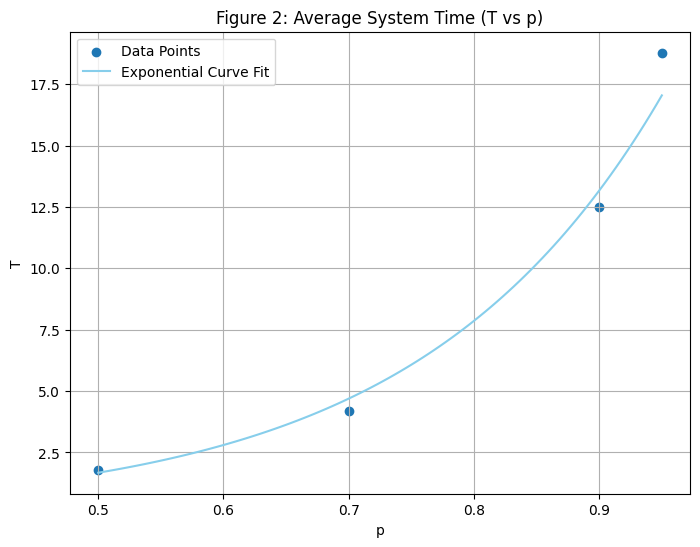

In [247]:
p = output[:, 2] #extracting the p values from the output array
T_bar = output[:, 4] #extracting the T values from the output array

p_smooth, T_bar_smooth = smooth_exponential_curve(p, T_bar) # Get the smooth exponential curve

plt.figure(figsize=(8, 6))

plt.scatter(p, T_bar, label='Data Points')
# Plot the smooth exponential curve
plt.plot(p_smooth, T_bar_smooth, color='skyblue', linestyle='-', label='Exponential Curve Fit')

plt.title("Figure 2: Average System Time (T vs p)")
plt.xlabel("p")
plt.ylabel("T")
plt.legend()
plt.grid(True)
plt.show()

**Table 1: a summary table with columns (λ, µ, ρ, W , T ,Lq, utilization)**

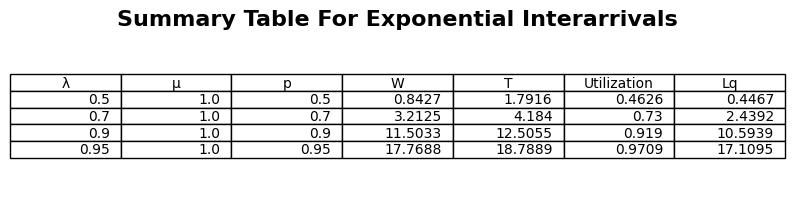

In [242]:
lam = output[:, 0]
mu = output[:, 1]
p = output[:, 2]

W_bar = output[:, 3]
W_bar = np.round(W_bar, 4) # Rounding to 4 decimal places for better readability

T_bar = output[:, 4]
T_bar = np.round(T_bar, 4) # Rounding to 4 decimal places for better readability

utilization = output[:, 5]
utilization = np.round(utilization, 4) # Rounding to 4 decimal places for better readability


Lq = output[:, 6]
Lq = np.round(Lq, 4)

data = {"λ": lam, "μ": mu, 'p': p, "W": W_bar, "T": T_bar, "Utilization": utilization, "Lq": Lq} #Creating a dictionary to hold the data


# Get the column headers
headers = list(data.keys())

# This creates a list of lists, which is the format matplotlib needs
table_data = list(zip(*data.values()))

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 2))

ax.axis('off') # Hide the plot axes

# Create the table
table = ax.table(cellText=table_data, colLabels=headers,   loc='center')  

ax.set_title("Summary Table For Exponential Interarrivals", fontsize=16, fontweight='bold', pad=10)        

table.auto_set_font_size(False)
table.set_fontsize(10) # Adjust the font size of the table

# Display the table
plt.show()

### Step 5: Effect of wrong modeling

replacing exponential interarrivals with uniform interarrivals

Similarly to Step 4, Create a function that generates values of p, mean waiting time, mean system time, utilization and time-average queue length 

This time using uniform interarrival times

In [236]:
# Function that generates performance metrics using uniform interarrival times instead of exponential interarrival times
# Function takes in a 2D array of parameters (lambda, mu) and number of slots
def wrong_modeling(params, slots):
    output_metrics = np.empty((params.shape[0], 7))
    for i in range(params.shape[0]):
        lam = params[i][0]
        mu = params[i][1]
        
        interarrival_times = np.random.uniform(0, 2/lam, size=slots) # Using uniform interarrival times instead of exponential
        arrival_times = np.cumsum(interarrival_times)
        serviceDurations = np.random.exponential(1/mu, slots)
        
        means, departure_times, service_start_times = time_mean(arrival_times, serviceDurations, slots)
        W_bar = means[0]
        T_bar = means[1]
        utilization = (np.sum(serviceDurations))/(departure_times[-1] - arrival_times[0])
        p = lam/mu
        Lq = calculating_Lq(arrival_times, service_start_times)
        output_metrics[i] = np.array([lam, mu, p, W_bar, T_bar, utilization, Lq])
    
    return output_metrics
        
parameters = np.array([[0.5, 1.0], [0.7, 1.0], [0.9, 1.0], [0.95, 1.0]])

output_wrong = wrong_modeling(parameters, slots)

Extract all the parameters of the wrong model simulation

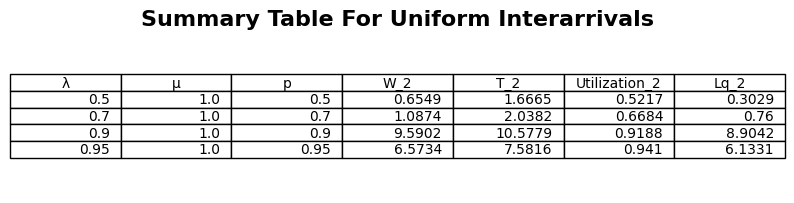

In [243]:
lam_2 = output_wrong[:, 0]
mu_2 = output_wrong[:, 1]
p_2 = output_wrong[:, 2]

W_bar_2 = output_wrong[:, 3]
W_bar_2 = np.round(W_bar_2, 4) # Rounding to 4 decimal places for better readability

T_bar_2 = output_wrong[:, 4]
T_bar_2 = np.round(T_bar_2, 4) # Rounding to 4 decimal places for better readability

utilization_2 = output_wrong[:, 5]
utilization_2 = np.round(utilization_2, 4) # Rounding to 4 decimal places for better readability

Lq_2 = output_wrong[:, 6]
Lq_2 = np.round(Lq_2, 4)

data = {"λ": lam_2, "μ": mu_2, 'p': p_2, "W_2": W_bar_2, "T_2": T_bar_2, "Utilization_2": utilization_2, "Lq_2": Lq_2} #Creating a dictionary to hold the data

# Get the column headers
headers = list(data.keys())

# This creates a list of lists, which is the format matplotlib needs
table_data = list(zip(*data.values()))

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 2))

ax.axis('off') # Hide the plot axes

# Create the table
table = ax.table(cellText=table_data, colLabels=headers,   loc='center') 

ax.set_title("Summary Table For Uniform Interarrivals", fontsize=16, fontweight='bold', pad=10)         

table.auto_set_font_size(False)
table.set_fontsize(10) # Adjust the font size of the table

# Display the table
plt.show()


**Figure 3: W vs. ρ for (i) exponential interarrivals, (ii) uniform interarrivals**

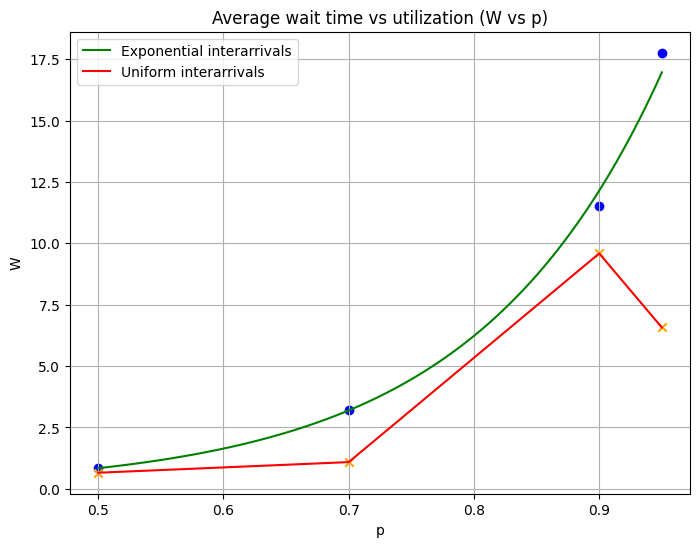

In [248]:
p_smooth, W_bar_smooth = smooth_exponential_curve(p, W_bar) # Get the smooth exponential curve


plt.figure(figsize=(8, 6))

plt.scatter(p, W_bar, color='blue', marker='o') # Plotting W vs p for exponential interarrivals
plt.scatter(p, W_bar_2, marker='x', color='orange') # Plotting W vs p for uniform interarrivals

# Plot the smooth exponential curve
plt.plot(p_smooth, W_bar_smooth, color='green', linestyle='-', label='Exponential interarrivals')
# plot the W vs p for uniform interarrivals
plt.plot(p, W_bar_2, color='Red', linestyle='-', label='Uniform interarrivals')

plt.title("Average wait time vs utilization (W vs p)")
plt.xlabel("p")
plt.ylabel("W")
plt.legend()
plt.grid(True)
plt.show()


**Figure 4: Lq vs. ρ for (i) exponential interarrivals, (ii) uniform interarrivals**

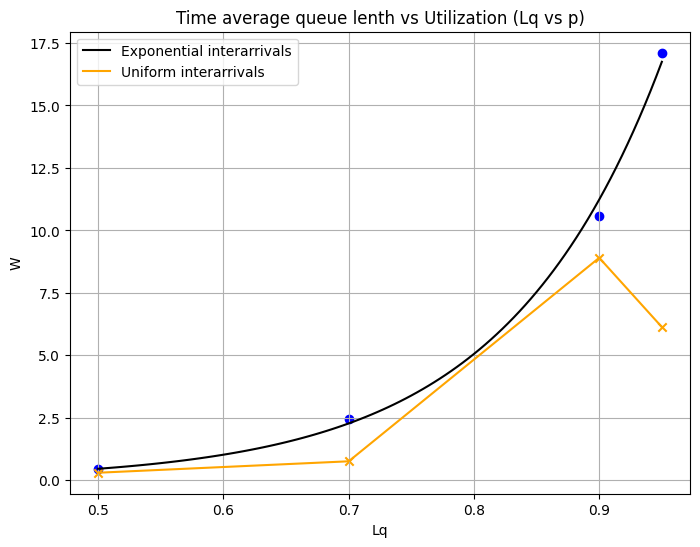

In [249]:
p_smooth, Lq_smooth = smooth_exponential_curve(p, Lq)

plt.figure(figsize=(8, 6))

plt.scatter(p, Lq, color='blue', marker='o') # Plotting Lq vs p for exponential interarrivals
plt.scatter(p, Lq_2, marker='x', color='orange') # Plotting Lq vs p for uniform interarrivals
# Plot the smooth exponential curve
plt.plot(p_smooth, Lq_smooth, color='black', linestyle='-', label='Exponential interarrivals')
# plot the W vs p for uniform interarrivals
plt.plot(p, Lq_2, color='orange', linestyle='-', label='Uniform interarrivals')

plt.title("Time average queue lenth vs Utilization (Lq vs p)")
plt.xlabel("Lq")
plt.ylabel("W") 
plt.grid(True)
plt.legend()

plt.show()